# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [270]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [271]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile1 = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [272]:
profile = profile1.copy()

In [273]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [274]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [275]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Rename columns for consistency

In [276]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
profile.rename(columns={'id': 'person'}, inplace=True)

# Handle missing values in gender and income columns

In [277]:
profile['gender'].fillna('Unknown', inplace=True)
profile['income'].fillna(profile['income'].median(), inplace=True)

# Convert became_member_on to datetime and extract membership duration

In [278]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['membership_duration_days'] = (pd.to_datetime('today') - profile['became_member_on']).dt.days

In [279]:
# Encode the gender column using One-Hot Encoding
profile = pd.get_dummies(profile, columns=['gender'])

In [280]:
# Expand transcript event data
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id') or x.get('offer_id'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', 0))
transcript.drop(columns=['value'], inplace=True)

In [281]:
# Separate the event column into binary columns
event_types = ['offer received', 'offer viewed', 'offer completed', 'transaction']
for event in event_types:
    transcript[event.replace(" ", "_")] = (transcript['event'] == event).astype(int)
transcript.drop(columns=['event'], inplace=True)

In [282]:
# Expand the channels column into separate binary columns
channels = ['email', 'mobile', 'social', 'web']
for channel in channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
portfolio.drop(columns=['channels'], inplace=True)

In [283]:
# Encode the offer_type column using Label Encoding
label_encoder = LabelEncoder()
portfolio['offer_type_encoded'] = label_encoder.fit_transform(portfolio['offer_type'])

In [284]:
# Create offer-related features
portfolio['offer_difficulty'] = portfolio['difficulty']
portfolio['offer_reward'] = portfolio['reward']
portfolio['offer_duration'] = portfolio['duration']

In [285]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,offer_type_encoded,offer_difficulty,offer_reward,offer_duration
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,0,10,10,7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0,10,10,5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,2,0,0,4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,0,5,5,7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,1,20,5,10


In [286]:
# Merge transcript with profile
df = transcript.merge(profile, on='person', how='left')

In [287]:
merged_df = df.merge(portfolio[['offer_id', 'offer_type','offer_difficulty','offer_reward','offer_duration','offer_type_encoded']], on='offer_id', how='left')

In [288]:
# Display merged DataFrame
merged_df.head()

,person,time,offer_id,amount,offer_received,offer_viewed,offer_completed,transaction,age,became_member_on,income,membership_duration_days,gender_F,gender_M,gender_O,gender_Unknown,offer_type,offer_difficulty,offer_reward,offer_duration,offer_type_encoded
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,0,0,0,75,2017-05-09,100000.0,2845,True,False,False,False,bogo,5.0,5.0,7.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,1,0,0,0,118,2017-08-04,64000.0,2758,False,False,False,True,discount,20.0,5.0,10.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,1,0,0,0,68,2018-04-26,70000.0,2493,False,True,False,False,discount,10.0,2.0,7.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,1,0,0,0,118,2017-09-25,64000.0,2706,False,False,False,True,discount,10.0,2.0,10.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1,0,0,0,118,2017-10-02,64000.0,2699,False,False,False,True,bogo,10.0,10.0,5.0,0.0


# Feature Engineering

In [289]:
# Create customer-level aggregated features
total_spent = merged_df.groupby('person')['amount'].sum().rename('total_spent')
average_transaction_amount = merged_df.groupby('person')['amount'].mean().rename('average_transaction_amount')
offer_response_rate = (merged_df.groupby('person')['offer_completed'].sum() / merged_df.groupby('person')['offer_received'].sum()).fillna(0).rename('offer_response_rate')

In [290]:
# Merge aggregated features back into the main DataFrame
customer_features = pd.concat([total_spent, average_transaction_amount, offer_response_rate], axis=1)
merged_df = merged_df.merge(customer_features, on='person', how='left')

In [291]:
merged_df.head()

,person,time,offer_id,amount,offer_received,offer_viewed,offer_completed,transaction,age,became_member_on,income,membership_duration_days,gender_F,gender_M,gender_O,gender_Unknown,offer_type,offer_difficulty,offer_reward,offer_duration,offer_type_encoded,total_spent,average_transaction_amount,offer_response_rate
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,0,0,0,75,2017-05-09,100000.0,2845,True,False,False,False,bogo,5.0,5.0,7.0,0.0,159.27,8.848333,0.75
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,1,0,0,0,118,2017-08-04,64000.0,2758,False,False,False,True,discount,20.0,5.0,10.0,1.0,4.65,0.422727,0.00
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,1,0,0,0,68,2018-04-26,70000.0,2493,False,True,False,False,discount,10.0,2.0,7.0,1.0,57.73,4.810833,0.50
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,1,0,0,0,118,2017-09-25,64000.0,2706,False,False,False,True,discount,10.0,2.0,10.0,1.0,0.00,0.000000,0.00
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1,0,0,0,118,2017-10-02,64000.0,2699,False,False,False,True,bogo,10.0,10.0,5.0,0.0,0.24,0.021818,0.00


In [292]:
# Calculate time differences between offer events
merged_df['time_diff_received_viewed'] = merged_df.groupby(['person', 'offer_id'])['offer_viewed'].cumsum() - merged_df.groupby(['person', 'offer_id'])['offer_received'].cumsum()
merged_df['time_diff_viewed_completed'] = merged_df.groupby(['person', 'offer_id'])['offer_completed'].cumsum() - merged_df.groupby(['person', 'offer_id'])['offer_viewed'].cumsum()
merged_df['time_diff_received_completed'] = merged_df.groupby(['person', 'offer_id'])['offer_completed'].cumsum() - merged_df.groupby(['person', 'offer_id'])['offer_received'].cumsum()

In [293]:
merged_df.head()

,person,time,offer_id,amount,offer_received,offer_viewed,offer_completed,transaction,age,became_member_on,income,membership_duration_days,gender_F,gender_M,gender_O,gender_Unknown,offer_type,offer_difficulty,offer_reward,offer_duration,offer_type_encoded,total_spent,average_transaction_amount,offer_response_rate,time_diff_received_viewed,time_diff_viewed_completed,time_diff_received_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,0,0,0,75,2017-05-09,100000.0,2845,True,False,False,False,bogo,5.0,5.0,7.0,0.0,159.27,8.848333,0.75,-1.0,0.0,-1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,1,0,0,0,118,2017-08-04,64000.0,2758,False,False,False,True,discount,20.0,5.0,10.0,1.0,4.65,0.422727,0.00,-1.0,0.0,-1.0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,1,0,0,0,68,2018-04-26,70000.0,2493,False,True,False,False,discount,10.0,2.0,7.0,1.0,57.73,4.810833,0.50,-1.0,0.0,-1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,1,0,0,0,118,2017-09-25,64000.0,2706,False,False,False,True,discount,10.0,2.0,10.0,1.0,0.00,0.000000,0.00,-1.0,0.0,-1.0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1,0,0,0,118,2017-10-02,64000.0,2699,False,False,False,True,bogo,10.0,10.0,5.0,0.0,0.24,0.021818,0.00,-1.0,0.0,-1.0


In [294]:
# Create age groups and income brackets
merged_df['age_group'] = pd.cut(merged_df['age'], bins=[0, 25, 40, 60, 100], labels=['<25', '25-40', '40-60', '60+'])
merged_df['income_bracket'] = pd.cut(merged_df['income'], bins=[0, 40000, 70000, 100000, 150000], labels=['Low', 'Medium', 'High', 'Very High'])


In [295]:
# Display all columns
pd.set_option('display.max_columns', None)

In [296]:
merged_df.head()

,person,time,offer_id,amount,offer_received,offer_viewed,offer_completed,transaction,age,became_member_on,income,membership_duration_days,gender_F,gender_M,gender_O,gender_Unknown,offer_type,offer_difficulty,offer_reward,offer_duration,offer_type_encoded,total_spent,average_transaction_amount,offer_response_rate,time_diff_received_viewed,time_diff_viewed_completed,time_diff_received_completed,age_group,income_bracket
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,0,0,0,75,2017-05-09,100000.0,2845,True,False,False,False,bogo,5.0,5.0,7.0,0.0,159.27,8.848333,0.75,-1.0,0.0,-1.0,60+,High
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,1,0,0,0,118,2017-08-04,64000.0,2758,False,False,False,True,discount,20.0,5.0,10.0,1.0,4.65,0.422727,0.00,-1.0,0.0,-1.0,NaN,Medium
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,1,0,0,0,68,2018-04-26,70000.0,2493,False,True,False,False,discount,10.0,2.0,7.0,1.0,57.73,4.810833,0.50,-1.0,0.0,-1.0,60+,Medium
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,1,0,0,0,118,2017-09-25,64000.0,2706,False,False,False,True,discount,10.0,2.0,10.0,1.0,0.00,0.000000,0.00,-1.0,0.0,-1.0,NaN,Medium
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1,0,0,0,118,2017-10-02,64000.0,2699,False,False,False,True,bogo,10.0,10.0,5.0,0.0,0.24,0.021818,0.00,-1.0,0.0,-1.0,NaN,Medium


# EDA

In [125]:

# Calculate aggregate metrics by demographic groups
demo_agg = merged_df.groupby(['age_group', 'income_bracket'])[['total_spent', 'average_transaction_amount', 'offer_response_rate']].mean().reset_index()

/tmp/ipykernel_13/2194258355.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demo_agg = merged_df.groupby(['age_group', 'income_bracket'])[['total_spent', 'average_transaction_amount', 'offer_response_rate']].mean().reset_index()


In [126]:
demo_agg.head(30)

,age_group,income_bracket,total_spent,average_transaction_amount,offer_response_rate
0,<25,Low,83.818633,3.292456,0.404090
1,<25,Medium,110.959487,4.595208,0.474447
2,<25,High,134.905859,5.713894,0.486659
3,<25,Very High,NaN,NaN,NaN
4,25-40,Low,82.277080,3.353971,0.437908
5,25-40,Medium,119.562901,4.864603,0.510144
6,25-40,High,179.794804,7.771634,0.591099
7,25-40,Very High,NaN,NaN,NaN
8,40-60,Low,72.528130,3.039521,0.407826
9,40-60,Medium,120.250614,5.249896,0.537619


# Visualization of customer demographics

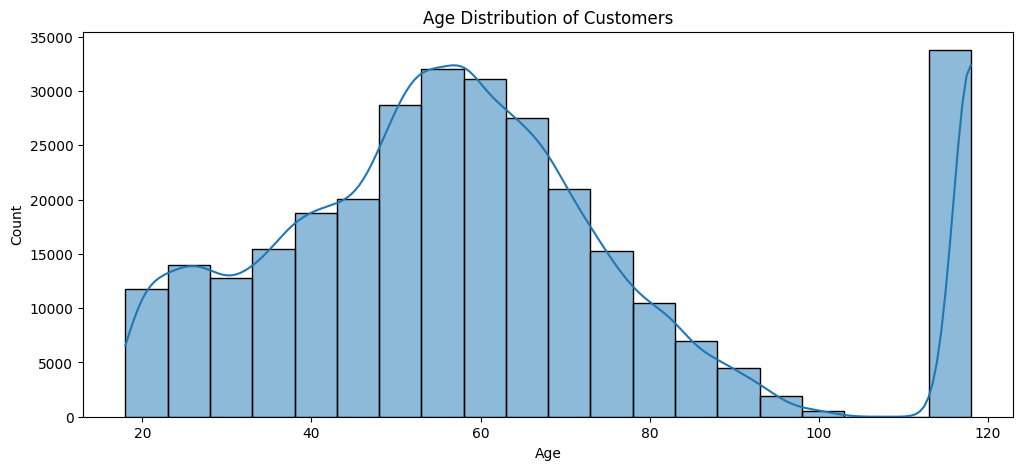

In [127]:
plt.figure(figsize=(12, 5))
sns.histplot(merged_df['age'], bins=20, kde=True)
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

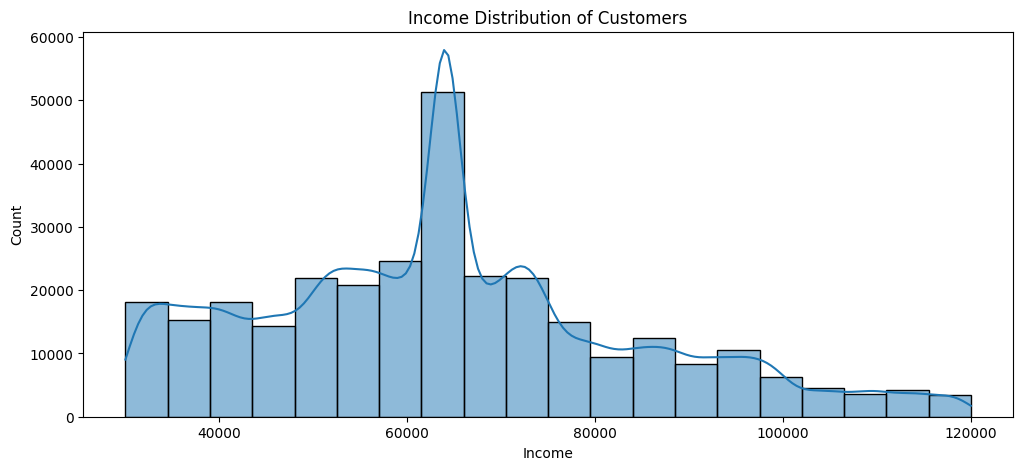

In [128]:
plt.figure(figsize=(12, 5))
sns.histplot(merged_df['income'], bins=20, kde=True)
plt.title("Income Distribution of Customers")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

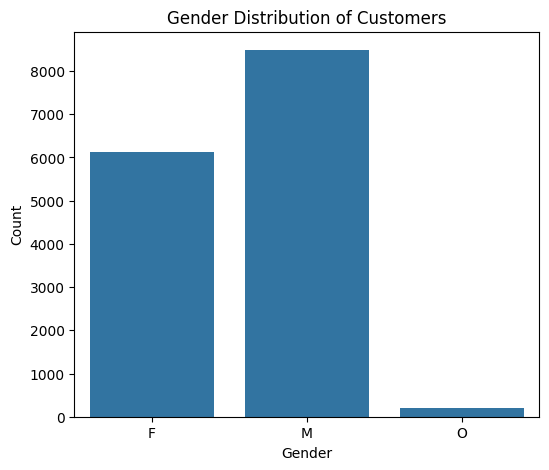

In [129]:
plt.figure(figsize=(6, 5))
sns.countplot(x='gender', data=profile1)
plt.title("Gender Distribution of Customers")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Analyze response rates for different offer types

In [130]:
offer_type_response = merged_df.groupby('offer_type')[['offer_received', 'offer_completed']].sum()
offer_type_response['response_rate'] = offer_type_response['offer_completed'] / offer_type_response['offer_received']

In [131]:
offer_type_response.head()

,offer_received,offer_completed,response_rate
offer_type,,,
bogo,30499,15669,0.513755
discount,30543,17910,0.586386
informational,15235,0,0.000000


/tmp/ipykernel_13/474900223.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=offer_type_response.index, y=offer_type_response['response_rate'], palette='viridis')


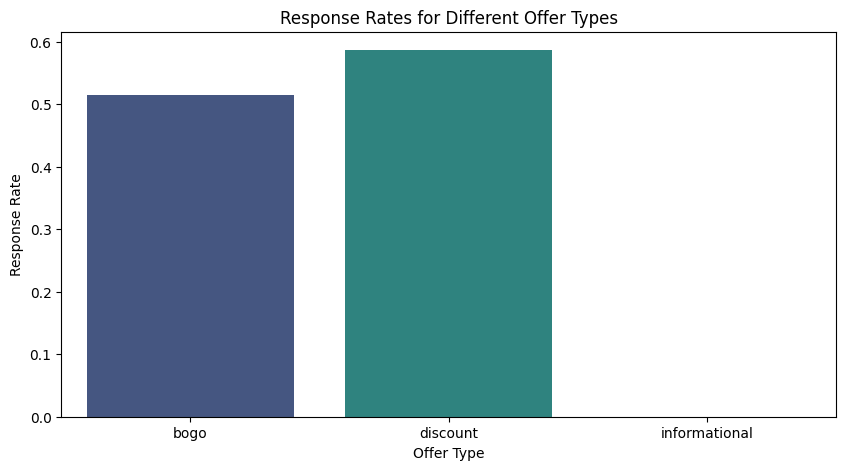

In [132]:
# Plot offer response rates
plt.figure(figsize=(10, 5))
sns.barplot(x=offer_type_response.index, y=offer_type_response['response_rate'], palette='viridis')
plt.title("Response Rates for Different Offer Types")
plt.xlabel("Offer Type")
plt.ylabel("Response Rate")
plt.show()

# Explore correlations between demographic features and offer completion rates

In [133]:
correlation_matrix = merged_df[['age', 'income', 'membership_duration_days', 'offer_completed']].corr()

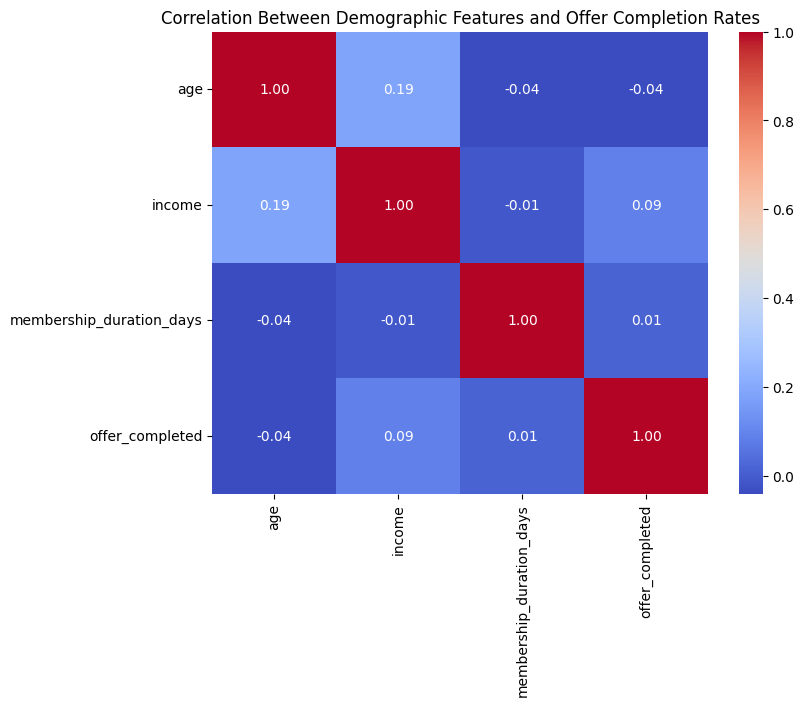

In [134]:
# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Demographic Features and Offer Completion Rates")
plt.show()

# Model Building

In [297]:
merged_df.dtypes

person                                  object
time                                     int64
offer_id                                object
amount                                 float64
offer_received                           int64
offer_viewed                             int64
offer_completed                          int64
transaction                              int64
age                                      int64
became_member_on                datetime64[ns]
income                                 float64
membership_duration_days                 int64
gender_F                                  bool
gender_M                                  bool
gender_O                                  bool
gender_Unknown                            bool
offer_type                              object
offer_difficulty                       float64
offer_reward                           float64
offer_duration                         float64
offer_type_encoded                     float64
total_spent  

In [299]:
features = ['age', 'income', 'membership_duration_days', 'offer_type_encoded', 'offer_difficulty', 'offer_reward', 'offer_duration', 'total_spent', 'average_transaction_amount', 'offer_response_rate', 'time_diff_received_viewed', 'time_diff_viewed_completed', 'time_diff_received_completed']

In [300]:
# Select relevant features for the model

X = merged_df[features]
y = merged_df['offer_completed']

In [307]:
# Your classes list
classes = [0, 1]

# Convert the list to a numpy array
classes_array = np.array(classes)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes_array, y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [308]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [309]:

# Train a machine learning model
model = RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5615101390339067,
                                     1: 4.564370588760832},
                       random_state=42)

In [310]:
# Make predictions
y_pred = model.predict(X_test)

In [312]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, roc_auc_score

In [313]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [314]:
print(f"Model Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.97
Precision: 0.82
Recall: 0.96
ROC-AUC Score: 0.97
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     54542
           1       0.82      0.96      0.88      6765

    accuracy                           0.97     61307
   macro avg       0.91      0.97      0.93     61307
weighted avg       0.98      0.97      0.97     61307



In [316]:
# Identify which demographic groups respond best to which offer types
demographic_response = merged_df.groupby(['age_group', 'income_bracket', 'offer_type'])['offer_completed'].mean().reset_index()
print(demographic_response.sort_values(by='offer_completed', ascending=False))

   age_group income_bracket     offer_type  offer_completed
46       60+      Very High       discount         0.331898
34     40-60      Very High       discount         0.327851
43       60+           High       discount         0.306391
33     40-60      Very High           bogo         0.302882
45       60+      Very High           bogo         0.299161
31     40-60           High       discount         0.298055
42       60+           High           bogo         0.283930
19     25-40           High       discount         0.276641
30     40-60           High           bogo         0.276390
28     40-60         Medium       discount         0.264362
16     25-40         Medium       discount         0.262517
40       60+         Medium       discount         0.257665
4        <25         Medium       discount         0.257495
18     25-40           High           bogo         0.251479
37       60+            Low       discount         0.247432
13     25-40            Low       discou

/tmp/ipykernel_13/988848038.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demographic_response = merged_df.groupby(['age_group', 'income_bracket', 'offer_type'])['offer_completed'].mean().reset_index()


**Top-Performing Groups**

Older and Higher-Income Customers Prefer Discounts

Customers aged 60+ with Very High income had the highest completion rates for discount offers (33.19%).
The 40-60 age group with Very High income followed closely (32.79%).
The 60+ group with High income also had a relatively high response rate (30.64%).

**Insight**: Older, wealthier customers are more likely to complete discount-based offers, indicating they respond well to direct price reductions.
BOGO Offers Also Attract High-Income, Older Customers

The 40-60 age group with Very High income had a 30.29% completion rate for BOGO (Buy-One-Get-One) offers.
The 60+ group with Very High income followed closely at 29.92%.

**Insight**: BOGO offers also appeal to high-income customers, but at slightly lower completion rates than discounts.
Middle-Income and Younger Customers Have Lower Response Rates

Customers in the 25-40 and <25 age groups had lower completion rates for both discount and BOGO offers.
The Medium-income 25-40 group had a 26.25% completion rate for discounts, lower than their high-income counterparts.
The Low-income <25 group had one of the lowest completion rates (22.90% for discounts and 16.10% for BOGO).

**Insight**: Younger, lower-income customers are less responsive to these promotional offers, possibly due to different spending habits or financial constraints.



**Underperforming Offers**

Informational Offers Had 0% Completion Rate

Across all demographics, informational offers had no recorded completions (0%).
Insight: This indicates that purely informational offers (e.g., brand awareness campaigns) do not directly lead to customer engagement, suggesting they might not be the most effective promotion type.
Gaps in Data for Very High-Income, Younger Customers

No completion data was recorded for customers under 25 with Very High income, across all offer types.
This might indicate a lack of targeted offers or lower participation rates from this group.



**Key Takeaways & Recommendations**

Focus Discount Offers on Older, Wealthier Customers

Discounts are the most effective offer type, especially for customers aged 40-60 and 60+ with high to very high incomes.
Starbucks could personalize these offers for this demographic to maximize engagement.
Reevaluate Informational Offers

Since informational offers had a 0% completion rate, they may need to be redesigned.
Starbucks could consider combining them with monetary incentives to drive engagement.
Encourage Engagement Among Younger Customers

Lower-income and younger customers (<25) had low completion rates, even for discounts.
Starbucks could experiment with smaller rewards, gamification, or loyalty incentives to improve engagement.
Investigate the Lack of Data for High-Income Younger Customers

If very high-income younger customers are underrepresented, Starbucks might be missing an opportunity.
Further analysis is needed to determine whether they ignore offers, are not targeted, or behave differently.